In [121]:
import requests
import pandas as pd
import numpy as np
import csv
from termcolor import colored

In [130]:
##make all pairs of (x,y)

## increase the points = 10 if u want more information
x = np.linspace(35.544239, 43.87686, 20)
y = np.linspace(-10.0494, 3.969154, 20)

all_pairs = []
for i in x:
    for j in y:
        all_pairs.append((i,j))
df = pd.DataFrame(all_pairs , columns = ["lat","lon"])
df.head()

,lat,lon
0,35.544239,-10.049400
1,35.544239,-9.311581
2,35.544239,-8.573763
3,35.544239,-7.835944
4,35.544239,-7.098125


In [68]:
df.shape

(100, 2)

In [138]:
##http request to api 
##change timeout if u do not want to wait for the proxy a lot

def get_data(lat, lon, proxy , timeout = 5):
    url = f"https://apps.solargis.com/api/data/lta?loc={lat},{lon}"

    requests.request.headers = {
        "User-Agent":"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36"
    }
    response = requests.request("GET",
                                url,
                                proxies={
                                    "http": proxy,
                                    "https": proxy
                                },
                                timeout=timeout)
    if response.status_code == 200:
        return response.json().get("annual").get("data")
    
    ##returns none if request wasn't succesful
    return

In [118]:
def get_proxies():
    proxies = []
    with open("proxies.csv") as f:
        reader = csv.reader(f)
        for row in reader:
            proxies.append(row[0])
    return proxies

##beware proxies fail sometimes..only ones i found functional for free at least
proxies = get_proxies()
proxies

['208.82.61.66:3128',
 '134.238.252.143:8080',
 '75.126.253.8:8080',
 '178.63.237.147:8080',
 '46.105.178.147:3128',
 '44.204.196.8:3128']

In [137]:
from itertools import cycle
import time
#infinite loop around proxies
prox_gen = cycle(proxies)

In [135]:
#store all json data retrieved from api
all_data = []

##index from which the process starts
last_succesful_index = 0

In [136]:
## This process might TAKE A LOT on the basis of your patience and connection time...
## well you can always find better proxy list online
## if u find any bugs please let me know!

flag = True
for idx , row in df.iloc[last_succesful_index:].iterrows():
    x , y = row.values
    print("*"*50 + f"\n ITERATION={idx+1}| Fetching data for lat={x:.2f},lon={y:.2f}")
    #start by using proxies one-by-one until one succeeds
    ## we start by using proxy one
    failures = 0
    for proxy in prox_gen:
        print(f"Attempting sourcing with proxy {proxy}...")
        try:
            ##send HTTP request
            data = get_data(x , y , proxy)

            ##store data
            data.update({"lat":x,"lon":y})
            all_data.append(data)
            print("Dictionary has been updated!")

            ##break the infinite loop and continue to next (x,y)
            break
        except Exception as e:
            print(colored(f"PROXY {proxy} FAILED! Error: {e}","red"))
            ##counting failed attempts
            failures += 1
            print(f"TOTAL FAILURES={failures}!")

            ##if we tried all proxies and none succeeded break loop
            ##and terminate
            if failures == len(proxies):
                flag = False
                break
            ##else retry with another proxy
            else:
                print("RETRYING...")
                continue

    ##all proxies failed = terminate procedure
    if not flag:
        ##before terminating store the last index on which the process
        ##was succesful to start from there
        last_succesful_index = idx - 1
        print(f"Last succesful index: {last_succesful_index}")
        break
    
    ##sleep a bit .. if u want uncomment this to slow down the process
    ##time.sleep(0.01)

Fetching data for lat=35.544239,lon=-10.0494
Attempting sourcing with proxy 208.82.61.66:3128...
Dictionary has been updated!
Fetching data for lat=35.544239,lon=-9.311581368421052
Attempting sourcing with proxy 134.238.252.143:8080...
Dictionary has been updated!
Fetching data for lat=35.544239,lon=-8.573762736842106
Attempting sourcing with proxy 75.126.253.8:8080...
PROXY 75.126.253.8:8080 FAILED! Error: HTTPSConnectionPool(host='apps.solargis.com', port=443): Max retries exceeded with url: /api/data/lta?loc=35.544239,-8.573762736842106 (Caused by ProxyError('Cannot connect to proxy.', OSError('Tunnel connection failed: 502 Bad Gateway')))
TOTAL FAILURES=1!
RETRYING...
Attempting sourcing with proxy 178.63.237.147:8080...
Dictionary has been updated!
Fetching data for lat=35.544239,lon=-7.835944105263158
Attempting sourcing with proxy 46.105.178.147:3128...
Dictionary has been updated!
Fetching data for lat=35.544239,lon=-7.098125473684211
Attempting sourcing with proxy 44.204.196.8

In [139]:
##cast your json into a dataframe
df = pd.DataFrame(all_data)

##finally save the data
df.to_csv("solar_updated.csv",index=False)

In [140]:
df.shape

(400, 17)

In [141]:
df.head(2)

,ELE,TEMP,CDD,HDD,LANDC,SLO,AZI,lat,lon,PVOUT_csi,GHI,DNI,DIF,D2G,GTI_opta,OPTA,POPUL
0,-3933,18.1250,421.0625,361.375,337,0.0,-1.0,35.544239,-10.049400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-3756,18.1875,438.9375,359.375,337,0.0,-1.0,35.544239,-9.311581,1679.769165,1822.328125,1841.148438,681.15625,0.375,2040.179688,29.0,NaN


In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")

<AxesSubplot:xlabel='lat', ylabel='lon'>

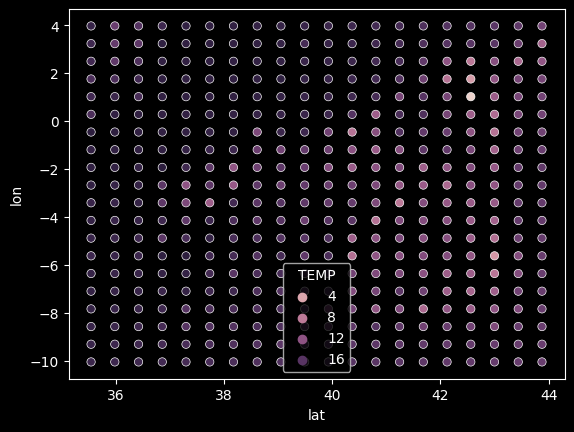

In [143]:
fig , ax = plt.subplots(nrows = 1 , ncols = 1)
sns.scatterplot(data = df[["lat","lon","TEMP"]] , 
            x = "lat" , y= 'lon',hue="TEMP" , cmap = "summer" , ax = ax)

In [144]:
## save figure
fig.savefig("temp_updated.png")